# ML Dataset

First attempt at an ML dataset.
Here one example will be one forecast date, and the corresponding observations.

We will use Arlan's top ten as features: https://docs.google.com/spreadsheets/d/1CzNvLExxJYhFAS_bWs97DON2xpG3zmDt-HHwQhqjpkE/edit#gid=0.

- *Surface Air Temperature (at 2 meter)*
- *Total precipitation*
- Soil moisture top 20 cm
- Snow Depth Water equivalent
- Sea Surface Temperature
- Sea Ice Cover
- Mean Sea Level Pressure
- Geopotential height@ 1000 hPa
- Geopotential height@ 200 hPa
- U-velocity (aka Zonal wind )@ 200 hPa
- U-velocity (aka Zonal wind )@ 850 hPa
- V-velocity (Meridional wind)@ 200 hPa
- V-velocity (Meridional wind)@ 850 hPa





In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import dask.distributed
import logging
import pathlib
import xarray as xr

from crims2s.data import normalize_dataset
from crims2s.dask import create_dask_cluster
from crims2s.mldataset import datestrings_from_input_dir, read_flat_fields, read_raw_obs
from crims2s.util import fix_dataset_dims

In [5]:
_logger = logging.getLogger(__name__)

In [6]:
logging.basicConfig(level=logging.INFO)

In [7]:
_logger

<Logger __main__ (INFO)>

## Initialize dask cluster

In [16]:
INPUT_DATA = '***BASEDIR***/training-input/'
INPUT_DATA_SPLIT_PLEV = '***BASEDIR***processed/training-input'
OBS_DATA = '***BASEDIR***/processed/training-output-reference/'
OBS_FILE_TEST = '***BASEDIR***/renku/forecast-like-observations_2020_biweekly_terciled.nc'
TRAIN_OBS = '***BASEDIR***/renku/hindcast-like-observations_2000-2019_biweekly_terciled.nc'
OUTPUT_DIR = '***BASEDIR***/training/2021-07-24-first'

RAW_OBS_T2M = '***BASEDIR***/raw-obs/obs_t2m_raw.nc'
RAW_OBS_PR = '***BASEDIR***/raw-obs/obs_pr_raw.nc'


CENTER = 'ecmwf'

In [9]:
output_path = pathlib.Path(OUTPUT_DIR)
output_path.mkdir(exist_ok=True, parents=True)

In [10]:
FLAT_FIELDS = ['t2m', 'tp', 'sm20', 'sst', 'ci', 'msl']
MULTILEVEL_FIELDS = [('u', [200, 850]), ('v', [200, 850]), ('gh', [1000, 200])]

In [11]:
train_obs_terciled = xr.open_dataset(TRAIN_OBS)

In [18]:
raw_obs = read_raw_obs(RAW_OBS_T2M, RAW_OBS_PR)

In [19]:
raw_obs

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 240, time: 8155)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2021-04-29
  * latitude   (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    pr         (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    source_dataset_name:  temperature daily from NOAA NCEP CPC: Climate Predi...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile

In [20]:
input_path = pathlib.Path(INPUT_DATA)
forecast_times = datestrings_from_input_dir(input_path, CENTER)

In [21]:
forecast_times[:10]

['20200528',
 '20200507',
 '20201112',
 '20200227',
 '20200723',
 '20201105',
 '20201224',
 '20200402',
 '20201001',
 '20200416']

In [22]:
sample = read_flat_fields(input_path, CENTER, FLAT_FIELDS, forecast_times[0])

In [25]:
sample

<xarray.Dataset>
Dimensions:             (forecast_dayofyear: 1, forecast_year: 20, latitude: 121, lead_time: 47, longitude: 240, realization: 11)
Coordinates:
  * lead_time           (lead_time) timedelta64[ns] 0 days 1 days ... 46 days
  * realization         (realization) int64 0 1 2 3 4 5 6 7 8 9 10
    forecast_time       (forecast_year) datetime64[ns] 2000-05-28 ... 2019-05-28
  * latitude            (latitude) float64 90.0 88.5 87.0 ... -87.0 -88.5 -90.0
  * longitude           (longitude) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
    valid_time          (forecast_year, lead_time) datetime64[ns] dask.array<chunksize=(20, 47), meta=np.ndarray>
  * forecast_dayofyear  (forecast_dayofyear) int64 149
  * forecast_year       (forecast_year) int64 2000 2001 2002 ... 2017 2018 2019
Data variables:
    msl                 (forecast_year, forecast_dayofyear, lead_time, realization, latitude, longitude) float32 dask.array<chunksize=(20, 1, 47, 11, 121, 240), meta=np.ndarray>
    siconc              (forecast_year, forecast_dayofyear, lead_time, realization, latitude, longitude) float32 dask.array<chunksize=(20, 1, 47, 11, 121, 240), meta=np.ndarray>
    sm20                (forecast_year, forecast_dayofyear, realization, lead_time, latitude, longitude) float32 dask.array<chunksize=(20, 1, 11, 47, 121, 240), meta=np.ndarray>
    sst                 (forecast_year, forecast_dayofyear, lead_time, realization, latitude, longitude) float32 dask.array<chunksize=(20, 1, 47, 11, 121, 240), meta=np.ndarray>
    t2m                 (forecast_year, forecast_dayofyear, lead_time, realization, latitude, longitude) float32 dask.array<chunksize=(20, 1, 47, 11, 121, 240), meta=np.ndarray>
    tp                  (forecast_year, forecast_dayofyear, lead_time, realization, latitude, longitude) float32 dask.array<chunksize=(20, 1, 47, 11, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-05-10T23:34 GRIB to CDM+CF via cfgrib-0.9.9...

In [27]:
raw_obs.sel(time=sample.valid_time.compute())

<xarray.Dataset>
Dimensions:        (forecast_year: 20, latitude: 121, lead_time: 47, longitude: 240)
Coordinates:
    time           (forecast_year, lead_time) datetime64[ns] 2000-05-28 ... 2...
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * lead_time      (lead_time) timedelta64[ns] 0 days 1 days ... 45 days 46 days
    forecast_time  (forecast_year) datetime64[ns] 2000-05-28 ... 2019-05-28
    valid_time     (forecast_year, lead_time) datetime64[ns] 2000-05-28 ... 2...
  * forecast_year  (forecast_year) int64 2000 2001 2002 2003 ... 2017 2018 2019
Data variables:
    t2m            (forecast_year, lead_time, latitude, longitude) float32 ...
    pr             (forecast_year, lead_time, latitude, longitude) float32 na...
Attributes:
    source_dataset_name:  temperature daily from NOAA NCEP CPC: Climate Predi...
    source_hosting:       IRIDL
    source_url:           http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/...
    created_by_software:  climetlab-s2s-ai-challenge
    created_by_script:    tools/observations/makefile

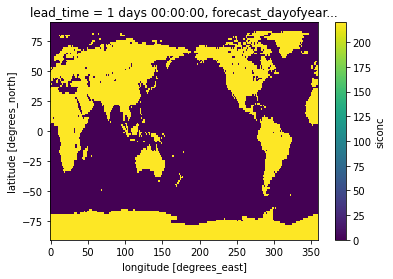

In [22]:
sample.isel(lead_time=[1]).isnull().sum(dim=['forecast_year', 'realization']).siconc.compute().plot()

In [ ]:
examples = process_one_forecast_week(forecast_times[0], train_obs_terciled)

In [ ]:
examples[10][1]

In [ ]:
for x, y in examples:
    forecast_time = y.forecast_time
    year = int(forecast_time.dt.year)
    month = int(forecast_time.dt.month)
    day = int(forecast_time.dt.day)
    filename = f'train_example_{year:04}{month:02}{day:02}.nc'
    
    output_file = output_path / filename
    
    x.to_netcdf(output_file, group='/x', mode='w')
    y.to_netcdf(output_file, group='/y', mode='a')

In [ ]:
y.isel(variable=0, lead_time=0, category=0).plot()

In [ ]:
!ls -lh {OUTPUT_DIR}

In [ ]:
tstt = xr.open_dataset(output_file, group='/y')

In [ ]:
tstt

In [ ]:
y

In [ ]:
forecast_times[:5]

In [ ]:
filenames = [f'{INPUT_DATA}/{CENTER}-hindcast-{f}-{forecast_times[0]}.nc' for f in flat_fields]
flat_dataset = xr.open_mfdataset(filenames, preprocess=fix_dataset_dims).isel(depth_below_and_layer=0, meanSea=0).drop(['depth_below_and_layer', 'meanSea'])

In [ ]:
flattened_fields = []

for field, levels in multilevel_fields:
    filename = f'{INPUT_DATA}/{CENTER}-hindcast-{field}-{forecast_times[0]}.nc'
    ds = fix_dataset_dims(xr.open_dataset(filename))
    print(ds)
    for level in levels:
        flattened_fields.append(ds.sel(plev=level).drop('plev').rename({field: f'{field}{level}'}))

In [ ]:
flattened_dataset = xr.merge(flattened_fields)

In [ ]:
ds = normalize_dataset(xr.merge([flattened_dataset, flat_dataset]))

In [ ]:
ds

In [ ]:
ds.mean().compute()

In [ ]:
ds.std().compute()

## Make examples from bigger dataset

In [ ]:
to_export_x = ds.isel(forecast_year=0).to_array().isel(forecast_dayofyear=0).transpose('lead_time', 'latitude', 'longitude', 'realization', 'variable')

In [ ]:
to_export_x

In [ ]:
to_export_x.to_netcdf('***BASEDIR***/mldataset/')

## Already terciled observations

In [ ]:
TRAIN_OBS = '***BASEDIR***/renku/hindcast-like-observations_2000-2019_biweekly_terciled.nc'
train_obs_terciled = xr.open_dataset(TRAIN_OBS)

In [ ]:
train_obs_terciled